
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Main Figure 2
-----

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway, rankdata, ranksums
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

import warnings
warnings.filterwarnings('ignore')

-----
##### Set up input / output directories

In [2]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

In [7]:
root_dir

'/Users/mehdi/Documents/MyRepos/mutsigs_therapy'

-----
##### Load helper scripts

In [3]:
sys.path.append(str(root_dir))
import scripts.plotter as plotter
import scripts.utils as ut
import scripts.ml_utils as mu

-----
##### Load & prepare data 

In [8]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.txt'), sep='\t', index_col=0)
kzm611_md['TMB'] = kzm611_md[['SBS', 'DBS', 'ID']].sum(axis=1)

low_samples = kzm611_md[kzm611_md.Burden=='low'].index.tolist()

In [9]:
kzm_tmb = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_TMBs.txt'), sep='\t', index_col=0)
kzm_tmb.tail(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB
IID_H158271_T01_01_WG01,Female,Primary-Naive,NBL,441.0,0.49344,770,5,85,5.0,26.0,860
IID_H158493_T01_01_WG01,Male,Primary-Treated,OST,5957.0,0.56608,5037,47,654,262.0,169.0,5738


In [183]:
kzm_tmb[kzm_tmb.Type=='OST'].Thr_State.value_counts()

Thr_State
Advanced-Treated    23
Primary-Treated     10
Primary-Naive       10
Advanced-Naive       1
Name: count, dtype: int64

In [47]:
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.median()

(8499.153846153846, 12045.6484375, 1824.0, 4751.5)

In [50]:
kzm_tmb[kzm_tmb.Thr_State=='Primary-Naive'].SBS.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Primary-Naive'].SBS.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.median()

(44714.71887550201, 12045.6484375, 2102.0, 4751.5)

In [48]:
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].DBS.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].DBS.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].DBS.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].DBS.median()

(191.30769230769232, 100.57421875, 9.0, 40.0)

In [49]:
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].ID.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].ID.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].ID.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].ID.median()

(1097.4615384615386, 3489.84765625, 350.0, 596.5)

In [40]:
import scipy.stats as stats

stats.ttest_ind(kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS, kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS)

TtestResult(statistic=-0.31745385596385384, pvalue=0.7511473577166596, df=267.0)

In [37]:
ranksums(kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS, kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS)

RanksumsResult(statistic=-1.8052777564069682, pvalue=0.07103122859545713)

In [7]:
kzm_tmb.SV.sum(), kzm_tmb.SV.min(), kzm_tmb.SV.max(), 1/2897.310462, 1472/2897.310462

(46324.0, 1.0, 1472.0, 0.0003451476854536689, 0.5080573929878006)

In [9]:
kzm_tmb.CN.sum(), kzm_tmb.CN.min(), kzm_tmb.CN.max(), kzm_tmb.CN.min()/2897.310462, kzm_tmb.CN.max()/2897.310462

(84119.0, 1.0, 4900.0, 0.0003451476854536689, 1.6912236587229774)

In [ ]:
'''kzm_tmb = kzm_tmb[kzm_tmb.Thr_State.isin(['Primary-Naive', 'Advanced-Treated'])]
kzm_tmb['Sex_bin'] = [0 if x=='Female' else 1 for x in kzm_tmb.Sex]
kzm_tmb['State_bin'] = [0 if x=='Primary-Naive' else 1 for x in kzm_tmb.Thr_State]
#kzm_tmb = kzm_tmb.dropna(axis=0)
kzm_tmb.head(3)'''

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin
KiCS0002_321321,Female,Advanced-Treated,GCT,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0,0,1
KiCS0003_285201,Female,Advanced-Treated,MFT,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0,0,1
KiCS0003_285202,Female,Advanced-Treated,MFT,1374.0,0.29,3670.0,20.0,396.0,37.0,4.0,4086.0,0,1


In [157]:
kzm_tmb.tail()

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin
IID_H158186_T01_01_WG01,Female,Advanced-Treated,NBL,6245.0,0.93702,8008,44,2837,42.0,39.0,10889,0,3
IID_H158186_T02_01_WG01,Female,Advanced-Treated,NBL,5550.0,0.32416,174714,94,24232,15.0,29.0,199040,0,3
IID_H158223_T01_01_WG01,Female,Advanced-Treated,OST,5646.0,0.87957,8528,183,762,313.0,201.0,9473,0,3
IID_H158271_T01_01_WG01,Female,Primary-Naive,NBL,441.0,0.49344,770,5,85,5.0,26.0,860,0,0
IID_H158493_T01_01_WG01,Male,Primary-Treated,OST,5957.0,0.56608,5037,47,654,262.0,169.0,5738,1,1


In [158]:
kzm_tmb.Thr_State.value_counts()

Thr_State
Advanced-Treated    256
Primary-Naive       249
Primary-Treated      93
Advanced-Naive       13
Name: count, dtype: int64

In [10]:
kzm_tmb['Sex_bin'] = [0 if x=='Female' else 1 for x in kzm_tmb.Sex]
state_dict = {'Primary-Naive': 0, 'Primary-Treated': 1, 'Advanced-Naive': 2, 'Advanced-Treated': 3}
kzm_tmb['State_bin'] = [state_dict[x] for x in kzm_tmb.Thr_State.tolist()]

In [22]:
def ranked_ancova_4groups(data, group_col='State_bin', mut_type='SBS'):
    df = data[[group_col, 'Age_days', 'Sex_bin', 'Purity', mut_type]].dropna()

    # Step 1: Rank the dependent variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress out covariates (Age, Sex, Purity) from ranked data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)

    # Step 3: Group residuals by unique group labels (sorted)
    groups = sorted(df[group_col].unique())
    grouped_values = [df[df[group_col] == g]['ResidualRanks'] for g in groups]

    # Perform one-way ANOVA across the groups
    f_stat, p_value = f_oneway(*grouped_values)

    # Print ANOVA results
    print("====== Ranked ANCOVA ======")
    print(f"Dependent Variable: {mut_type}")
    print(f"Groups: {groups}")
    print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_value:.4e}")

    # If significant, do post hoc tests
    if len(groups) > 2: # and p_value < 0.05:
        print("\nPost Hoc Test (Tukey's HSD):")
        tukey = pairwise_tukeyhsd(endog=df['ResidualRanks'], groups=df[group_col], alpha=0.05)
        print(tukey.summary())

        # Pairwise Wilcoxon rank-sum tests with FDR correction
        pvals = []
        comparisons = []
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                grp1 = df[df[group_col] == groups[i]]['ResidualRanks']
                grp2 = df[df[group_col] == groups[j]]['ResidualRanks']
                stat, p = ranksums(grp1, grp2)
                pvals.append(p)
                comparisons.append(f"{groups[i]} vs {groups[j]}")

        # Adjust p-values using Benjamini-Hochberg (FDR)
        rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

        pvals_l = []

        print("\nPairwise Wilcoxon tests with FDR correction:")
        for comp, pval_corr, rej in zip(comparisons, pvals_corrected, rejected):
            print(f"{comp}: p_adj={pval_corr:.4e}, significant={rej}")
            pvals_l.append((int(comp.split(' vs ')[0]), int(comp.split(' vs ')[1]), pval_corr))
        pvals = pd.DataFrame(pvals_l)
        pvals.columns = ['first', 'second', 'pv']

    return df, p_value, pvals


In [12]:
sbs_res, sbs_pval, sbs_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='SBS')


====== Ranked ANCOVA ======
Dependent Variable: SBS
Groups: [0, 1, 2, 3]
F-Statistic: 15.4760, P-Value: 1.0370e-09

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  26.7923 0.4997  -22.5039  76.0885  False
     0      2  14.7277 0.9877 -100.5726  130.028  False
     0      3  93.7729    0.0   57.5989  129.947   True
     1      2 -12.0646 0.9939 -132.0432  107.914  False
     1      3  66.9807 0.0027   17.8964 116.0649   True
     2      3  79.0452 0.2901  -36.1646 194.2551  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=1.8978e-01, significant=False
0 vs 2: p_adj=9.1112e-01, significant=False
0 vs 3: p_adj=3.0524e-11, significant=True
1 vs 2: p_adj=7.9347e-01, significant=False
1 vs 3: p_adj=1.6205e-03, significant=True
2 vs 3: p_adj=1.8978e-01, signi

In [13]:
dbs_res, dbs_pval, dbs_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='DBS')

====== Ranked ANCOVA ======
Dependent Variable: DBS
Groups: [0, 1, 2, 3]
F-Statistic: 24.2995, P-Value: 7.4120e-15

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  63.1139 0.0065   13.2176 113.0101   True
     0      2  12.9868 0.9918  -103.717 129.6906  False
     0      3 120.3527    0.0   83.7383 156.9671   True
     1      2 -50.1271  0.712 -171.5661  71.3119  False
     1      3  57.2388 0.0164    7.5571 106.9205   True
     2      3 107.3659 0.0836   -9.2463 223.9781  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=1.5120e-03, significant=True
0 vs 2: p_adj=6.7309e-01, significant=False
0 vs 3: p_adj=3.8465e-16, significant=True
1 vs 2: p_adj=3.0932e-01, significant=False
1 vs 3: p_adj=1.0177e-02, significant=True
2 vs 3: p_adj=7.3588e-02, signif

In [14]:
id_res, id_pval, id_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='ID')

====== Ranked ANCOVA ======
Dependent Variable: ID
Groups: [0, 1, 2, 3]
F-Statistic: 6.4201, P-Value: 2.7662e-04

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1 -11.7264 0.9287  -61.1911  37.7382  False
     0      2  -3.5169 0.9998 -119.2112 112.1775  False
     0      3   53.151  0.001   16.8533  89.4486   True
     1      2   8.2096 0.9981 -112.1791 128.5982  False
     1      3  64.8774 0.0041   15.6254 114.1294   True
     2      3  56.6678  0.587  -58.9358 172.2714  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=8.9122e-01, significant=False
0 vs 2: p_adj=9.1945e-01, significant=False
0 vs 3: p_adj=1.4793e-04, significant=True
1 vs 2: p_adj=9.1945e-01, significant=False
1 vs 3: p_adj=1.0776e-03, significant=True
2 vs 3: p_adj=5.8653e-01, signifi

In [16]:
tmb_res, tmb_pval, tmb_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='TMB')

====== Ranked ANCOVA ======
Dependent Variable: TMB
Groups: [0, 1, 2, 3]
F-Statistic: 15.2046, P-Value: 1.5021e-09

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  22.9868  0.624  -26.1653   72.139  False
     0      2  14.0977 0.9891 -100.8657 129.0611  False
     0      3  92.1963    0.0   56.1279 128.2647   True
     1      2  -8.8892 0.9975 -128.5172 110.7389  False
     1      3  69.2095 0.0017   20.2687 118.1503   True
     2      3  78.0986 0.2981  -36.7746 192.9718  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=2.8586e-01, significant=False
0 vs 2: p_adj=8.7820e-01, significant=False
0 vs 3: p_adj=4.0599e-11, significant=True
1 vs 2: p_adj=8.2725e-01, significant=False
1 vs 3: p_adj=1.0197e-03, significant=True
2 vs 3: p_adj=2.8556e-01, signi

In [17]:
sv_res, sv_pval, sv_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='SV')

====== Ranked ANCOVA ======
Dependent Variable: SV
Groups: [0, 1, 2, 3]
F-Statistic: 2.7502, P-Value: 4.2063e-02

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  23.2393  0.665  -29.2906  75.7692  False
     0      2 -32.5043 0.9103 -158.4805  93.4719  False
     0      3  39.8836 0.0415    1.0558  78.7114   True
     1      2 -55.7436 0.6906  -186.486  74.9988  False
     1      3  16.6443 0.8447  -35.6164   68.905  False
     2      3  72.3879 0.4492  -53.4763 198.2521  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=3.6808e-01, significant=False
0 vs 2: p_adj=5.1188e-01, significant=False
0 vs 3: p_adj=4.2155e-02, significant=True
1 vs 2: p_adj=3.6808e-01, significant=False
1 vs 3: p_adj=4.2630e-01, significant=False
2 vs 3: p_adj=3.6808e-01, signif

In [18]:
cnv_res, cnv_pval, cnv_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='CN')

====== Ranked ANCOVA ======
Dependent Variable: CN
Groups: [0, 1, 2, 3]
F-Statistic: 1.3401, P-Value: 2.6037e-01

Post Hoc Test (Tukey's HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper  reject
------------------------------------------------------
     0      1  25.1759 0.5933  -26.5868 76.9385  False
     0      2 -39.4071 0.8456 -163.3996 84.5853  False
     0      3  21.9187 0.4447  -16.0019 59.8393  False
     1      2  -64.583 0.5688 -193.4272 64.2612  False
     1      3  -3.2571 0.9985  -54.8776 48.3633  False
     2      3  61.3259 0.5793  -62.6073 185.259  False
------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=2.6574e-01, significant=False
0 vs 2: p_adj=4.9109e-01, significant=False
0 vs 3: p_adj=2.6574e-01, significant=False
1 vs 2: p_adj=2.6574e-01, significant=False
1 vs 3: p_adj=9.5566e-01, significant=False
2 vs 3: p_adj=2.6574e-01, significant=Fal

-----------
## Panel a

In [23]:
## Subset of metadata. Preparing df for plotting
kzm611_all = kzm_tmb.copy()
kzm611_sub = kzm_tmb.copy() #[kzm_tmb.Thr_State.isin(['Advanced-Treated', 'Primary-Naive'])]
kzm611_all.Thr_State = 'All Samples'
kzm611_mix = pd.concat([kzm611_sub, kzm611_all], axis=0)

## 2-line labels for better aesthetics
kzm611_mix['Thr_State2'] = [x.replace('-', '\n') if '-' in x else x for x in kzm611_mix.Thr_State]

In [234]:
#kzm611_mix['TMB'] = kzm611_mix[['SBS', 'DBS', 'ID']].sum(axis=1)
kzm611_mix.head()

,Sex,Thr_State,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Thr_State2
KiCS0002_321321,Female,Advanced-Treated,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0,0,1,Advanced\nTreated
KiCS0003_285201,Female,Advanced-Treated,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0,0,1,Advanced\nTreated
KiCS0003_285202,Female,Advanced-Treated,1374.0,0.29,3670.0,20.0,396.0,37.0,4.0,4086.0,0,1,Advanced\nTreated
KiCS0003_20_15220_A_02_00,Female,Advanced-Treated,5858.0,0.62,17044.0,58.0,2088.0,207.0,72.0,19190.0,0,1,Advanced\nTreated
KiCS0005_300238,Female,Primary-Naive,73.0,0.65,276.0,3.0,62.0,23.0,18.0,341.0,0,0,Primary\nNaive


In [24]:
## Define colors for plotting
#color_dict = {'All Samples': 'white', 'Primary\nNaive': 'lightsteelblue', 'Primary\nTreated': 'mistyrose', 'Advanced\nNaive': 'lightsteelblue', 'Advanced\nTreated': 'mistyrose'}
color_dict = {'All Samples': 'white', 'Primary\nNaive': 'linen', 'Primary\nTreated': 'lavender', 'Advanced\nNaive': 'linen', 'Advanced\nTreated': 'lavender'}

In [403]:
from importlib import reload
reload(plotter)

<module 'scripts.plotter' from '/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py'>

In [277]:
sbs_pvals

,first,second,pv
0,0,1,1.897803e-01
1,0,2,9.111186e-01
2,0,3,3.052357e-11
3,1,2,7.934680e-01
4,1,3,1.620457e-03
5,2,3,1.897803e-01


In [280]:
color_dict

{'All Samples': 'white',
 'Primary\nNaive': 'lightsteelblue',
 'Primary\nTreated': 'mistyrose',
 'Advanced\nNaive': 'lightsteelblue',
 'Advanced\nTreated': 'mistyrose'}

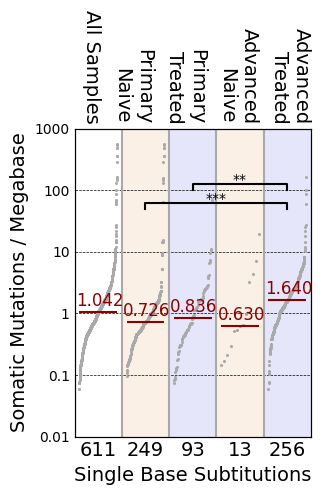

In [25]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'SBS']].copy(), sbs_pvals, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="Single Base Subtitutions", yaxis = "Somatic Mutations / Megabase", Yrange=[0.01, 1000])
#plt.savefig(os.path.join(fig_out, 'Fig_2a1.pdf'), bbox_inches="tight")

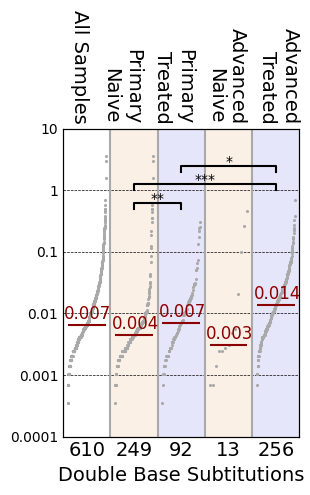

In [419]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'DBS']].copy(), dbs_pvals, scale='genome', color_dict=color_dict,
                        order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="Double Base Subtitutions", yaxis = "", Yrange=[0.0001, 10])
plt.savefig(os.path.join(fig_out, 'Fig_2a2.pdf'), bbox_inches="tight")

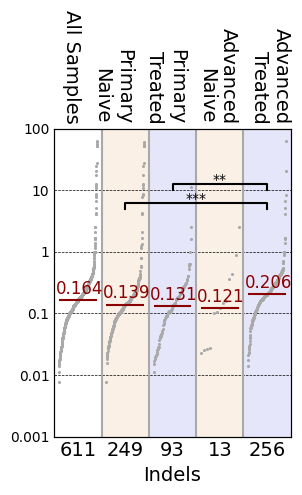

In [420]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'ID']].copy(), id_pvals, scale='genome', color_dict=color_dict,
                        order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="Indels", yaxis = "", Yrange=[0.001, 100])

plt.savefig(os.path.join(fig_out, 'Fig_2a3.pdf'), bbox_inches="tight")

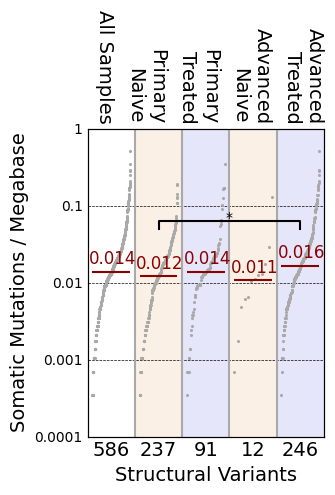

In [421]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'SV']].copy(), sv_pvals, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="Structural Variants", yaxis = "Somatic Mutations / Megabase", Yrange=[0.0001, 1])
plt.savefig(os.path.join(fig_out, 'Fig_2a4.pdf'), bbox_inches="tight")

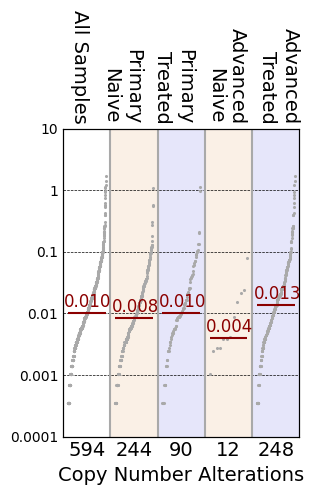

In [422]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'CN']].copy(), cnv_pvals, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="Copy Number Alterations", yaxis = "", Yrange=[0.0001, 10])
plt.savefig(os.path.join(fig_out, 'Fig_2a5.pdf'), bbox_inches="tight")

-----------
## Panel b

In [26]:
types10_md = kzm_tmb.copy()
types10_md = types10_md[types10_md.Thr_State.isin(['Primary-Naive', 'Advanced-Treated'])]
types10_md['Therapy2'] = ['Naive' if x=='Primary-Naive' else 'Treated' for x in types10_md.Thr_State]
## Label aesthetics
types10_md['prepost'] = types10_md.Type + '::' + types10_md.Therapy2
types10_md = types10_md[~types10_md.prepost.isin(['HB::Treated', 'UNK::Naive', 'UNK::Treated'])]

## Get rid of any type with <5 samples either pre or post therapy
low_types = [x.split('::')[0] for x in types10_md.prepost.value_counts()[types10_md.prepost.value_counts()<5].index]
types10_md = types10_md[~types10_md.Type.isin(low_types)]
types10_md.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Therapy2,prepost
KiCS0006_274243,Female,Advanced-Treated,NBL,3528.0,0.74,3842,30,180,28.0,17.0,4052,0,3,Treated,NBL::Treated
KiCS0010_270645,Male,Advanced-Treated,OST,4326.0,0.94,6761,51,1288,180.0,147.0,8100,1,3,Treated,OST::Treated


In [27]:
## calculate medians
median_diffs = []
for t in set([x.split('::')[0] for x  in types10_md.prepost.sort_values().unique()]):
    pret_median = np.median(np.log10(types10_md[types10_md.prepost==t+'::Naive'].SBS))
    post_median = np.median(np.log10(types10_md[types10_md.prepost==t+'::Treated'].SBS))
    median_diffs.append((t, post_median - pret_median))

## Sort df based on pre-post median increase
median_diffs_sorted = sorted(median_diffs, key=lambda x: x[1])
types10_sorted = [x+'::'+y for x in [i[0] for i in median_diffs_sorted] for y in ['Naive', 'Treated']]

In [28]:
types10_md2 = types10_md.copy()
#types10_md2['Sex'] = [0 if x=='Female' else 1 for x in types10_md2.Sex]
types10_md2['Therapy_bin'] = [0 if x=='Naive' else 1 for x in types10_md2.Therapy2]
types10_md2.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Therapy2,prepost,Therapy_bin
KiCS0006_274243,Female,Advanced-Treated,NBL,3528.0,0.74,3842,30,180,28.0,17.0,4052,0,3,Treated,NBL::Treated,1
KiCS0010_270645,Male,Advanced-Treated,OST,4326.0,0.94,6761,51,1288,180.0,147.0,8100,1,3,Treated,OST::Treated,1


In [33]:
def ranked_ancova_type(data, mut_type='SBS'):
    df = data[['Therapy_bin', 'Age_days', 'Sex_bin', 'Purity', mut_type]]
    df = df.dropna(axis=0)
    # Step 1: Rank the Dependent Variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress Out Covariates (Age and Sex) from Ranked Data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']

    # Fit linear regression on covariates
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)  # Residuals of ranked data

    # Step 3: Test Group Differences on Residuals
    group_0 = df[df['Therapy_bin'] == 0]['ResidualRanks']
    group_1 = df[df['Therapy_bin'] == 1]['ResidualRanks']

    # Perform an F-test on residual ranks (nonparametric equivalent of ANCOVA)
    f_stat, p_value = f_oneway(group_0, group_1)

    print(f"====== Ranked ANCOVA ======")
    print(f"====================== {mut_type}")
    print(f"F-Statistic: {f_stat}, P-Value: {p_value}")
    return p_value


In [34]:
pval_dict = {x: ranked_ancova_type(types10_md2[types10_md2.Type==x], mut_type='SBS') for x in list(set([y.split('::')[0] for y in types10_sorted]))}

====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 7.271979746302602, P-Value: 0.01831016828488064
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 5.758613636972101, P-Value: 0.028935917957457834
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 1.8954992917235625, P-Value: 0.18308481171763255
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 8.71684096333836, P-Value: 0.005964136224211855
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 4.840892212222991, P-Value: 0.03201123682633907
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 0.013981056690276656, P-Value: 0.9074451721646897
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 0.4211870084922789, P-Value: 0.521827927111638
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 21.87705367214205, P-Value: 6.215326320856459e-05
====== Ranked ANCOVA ======
====================== SBS
F-Statistic:

In [278]:
pval_dict

{'HGG': 0.476145883863628,
 'AML': 0.9074451721646897,
 'EWS': 0.521827927111638,
 'BALL': 6.215326320856459e-05,
 'EPD': 0.01831016828488064,
 'ERMS': 0.18308481171763255,
 'OST': 0.005964136224211855,
 'NBL': 0.03201123682633907,
 'ARMS': 0.028935917957457834}

In [30]:
tumor_dict = {'NBL::Naive': 'Neuroblastoma::Naive', 'NBL::Treated': 'Neuroblastoma::Treated',
              'OST::Naive': 'Osteosarcoma::Naive', 'OST::Treated': 'Osteosarcoma::Treated',
              'BALL::Naive': 'B-cell\nLeukemia::Naive', 'BALL::Treated': 'B-cell\nLeukemia::Treated',
              'ERMS::Naive': 'Embryonal\nRhabdomyosarcoma::Naive', 'ERMS::Treated': 'Embryonal\nRhabdomyosarcoma::Treated',
              'HGG::Naive': 'High-grade\nGlioma::Naive', 'HGG::Treated': 'High-grade\nGlioma::Treated',
              'EWS::Naive': 'Ewing\nSarcoma::Naive', 'EWS::Treated': 'Ewing\nSarcoma::Treated',
              'EPD::Naive': 'Ependymoma::Naive', 'EPD::Treated': 'Ependymoma::Treated',
              'AML::Naive': 'Acute\nMonocytic\nLeukemia::Naive', 'AML::Treated': 'Acute\nMonocytic\nLeukemia::Treated',
              'ARMS::Naive': 'Alveolar\nRhabdomyosarcoma::Naive', 'ARMS::Treated': 'Alveolar\nRhabdomyosarcoma::Treated'
              }

In [31]:
types10_md['full_name'] = [tumor_dict[x] for x in types10_md.prepost]

Yrange is a list
ARMS
OST
BALL
EPD
NBL


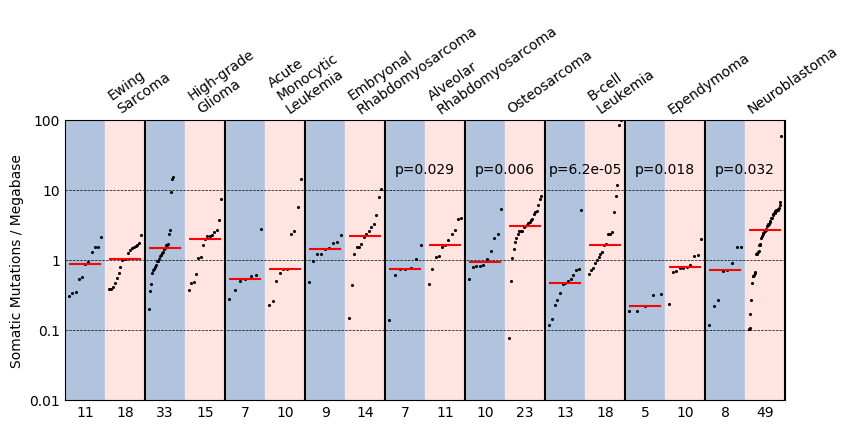

In [36]:
#TMB_plotter.plotTMB_generic
plotter.plotTMB_type(types10_md[['prepost', 'SBS']].copy(), pval_dict, scale='genome', Yrange=[0.01, 100], order=types10_sorted)
#plt.savefig(os.path.join(fig_out, 'Fig_2c.pdf'), bbox_inches="tight")

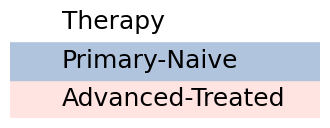

In [417]:
import matplotlib.pyplot as plt
mycolors = ['white', 'lightsteelblue', 'mistyrose']

labels = ['Therapy', 'Primary-Naive', 'Advanced-Treated']

fig, ax = plt.subplots(figsize=(4, 1))  # Taller figure for vertical layout

for i, (c, label) in enumerate(zip(mycolors[::-1], labels[::-1])):
    ax.add_patch(plt.Rectangle((0, i), 4, 4, color=c))
    ax.text(0.5, i + 0.5, label, va='center', ha='left', fontsize=18)

ax.set_xlim(0, 3)
ax.set_ylim(0, 2)
ax.axis('off')

plt.savefig(os.path.join(fig_out, 'Fig_2c_leg_rev.pdf'), bbox_inches="tight")
